#Mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/EVA2/Assignment8 

Mounted at /content/gdrive
/content/gdrive/My Drive/EVA2/Assignment8


#Imports 

In [2]:
from zipfile import ZipFile
import os
from tqdm.notebook import tqdm
import shutil
import torch
import torchvision
import cudas
import general_utils
from Transform_utils.transforme_album import Data
import general_utils
import torch.nn as nn
from torch.utils.data import DataLoader
from Models.sr_gan import Generator, Discriminator
from loss import GeneratorLoss
import matplotlib as plt

CUDA Available? True


#Unzip

In [3]:
!unzip -q /content/gdrive/My\ Drive/EVA2/Assignment8/WingedDrones.zip -d /

#Train vs Test count

In [4]:
import os
print("Train count: ", str(sum([len(files) for r,d, files in os.walk('/content/ZData/Train/Winged Drones/')])))
print("Test count: ", str(sum([len(files) for r,d, files in os.walk('/content/ZData/Val/Winged Drones/')])))

Train count:  3972
Test count:  1703


#Dataset/Dataloader


In [5]:
!rm -rf /content/ZData/Train/Winged\ Drones/WingedDrones_4416.jpg
!rm -rf /content/ZData/Train/Winged\ Drones/WingedDrones_957.jpg

In [6]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset =  data.getTestDataSet(train=False)
trainloader = data.getDataLoader(trainset, 4)
trainloader1 = data.getDataLoader(trainset, 4)
testloader = data.getDataLoader(testset, 4)
testloader1 = data.getDataLoader(testset, 4)
classes = ('Winged Drones')

Train Data size 3970
Test Data size 1703


#Display Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 64, 64])


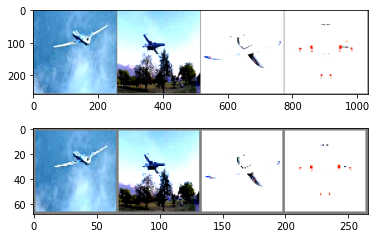

In [7]:
import matplotlib.pyplot as plt
# get some random training images
dataiter = iter(trainloader1)
images, target = dataiter.next()
im1 = images[0]
im2 = images[1]
print(im1.shape)
print(im2.shape)
plt.subplot(211)
general_utils.imshow(torchvision.utils.make_grid(im1))
plt.subplot(212)
general_utils.imshow(torchvision.utils.make_grid(im2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 64, 64])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])


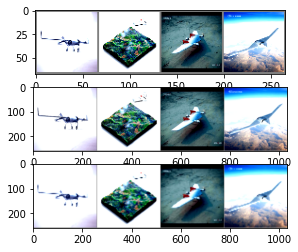

In [8]:
# get some random training images
dataiter = iter(testloader1)
images, target = dataiter.next()
im1 = images[0]
im2 = images[1]
im3 = images[2]
plt.subplot(311)
print(im1.shape)
general_utils.imshow(torchvision.utils.make_grid(im1))
plt.subplot(312)
print(im2.shape)
general_utils.imshow(torchvision.utils.make_grid(im2))
plt.subplot(313)
print(im3.shape)
general_utils.imshow(torchvision.utils.make_grid(im3))

#Loading Generator/Discriminator

In [7]:
device = torch.device("cuda" if cudas.cuda else "cpu")
netG = Generator(4).to(device)
netD = Discriminator().to(device)

#Summary

In [10]:
from torchsummary import summary
summary(netG, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,616
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
     ResidualBlock-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
      BatchNorm2d-10           [-1, 64, 64, 64]             128
            PReLU-11           [-1, 64, 64, 64]               1
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
    ResidualBlock-14           [-1, 64,

In [11]:
summary(netD, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         LeakyReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         LeakyReLU-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
       BatchNorm2d-7        [-1, 128, 128, 128]             256
         LeakyReLU-8        [-1, 128, 128, 128]               0
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        LeakyReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         295,168
      BatchNorm2d-13          [-1, 256, 64, 64]             512
        LeakyReLU-14          [-1, 256,

#Defining optimizer, loss

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
#criterion = nn.CrossEntropyLoss()
criterion = GeneratorLoss().to(device)
optimizerG = optim.Adam(netG.parameters()) 
optimizerD = optim.Adam(netD.parameters()) 
schedulerG = StepLR(optimizerG, step_size=10, gamma=0.1)
schedulerD = StepLR(optimizerD, step_size=10, gamma=0.1)

In [1]:
!pip install pytorch_ssim

In [6]:
from tqdm.notebook import tqdm
from Train_Test_utils.traine import train
from Train_Test_utils.teste import test
from torch.autograd import Variable
import matplotlib.pyplot as plt1
batch_size = 4
step=0
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}
for epoch in range(26):  # loop over the dataset multiple times
    for param_group in optimizerG.param_groups:
              print("lr : ",param_group['lr'])
    running_results, netG, netD, optimizerG, optimizerD = train(netG, netD, batch_size, device, trainloader, optimizerG, optimizerD, criterion, epoch)
    torch.save(netG.state_dict(), 'Generated_models/netG'+str(epoch)+'.pt')
    valing_results = test(netG, device, testloader, criterion, batch_size)
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])
    schedulerG.step()
    schedulerD.step()
    step+=1

print('Finished Training')

  0%|          | 0/993 [00:00<?, ?it/s]

lr :  0.001


[0/25] Loss_D: 0.8133 Loss_G: 1.3277 D(x): 0.4935 D(G(z)): 0.2976:   2%|▏         | 22/993 [00:13<09:32,  1.70it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[0/25] Loss_D: 0.9033 Loss_G: 0.9695 D(x): 0.4728 D(G(z)): 0.3679:  40%|████      | 400/993 [04:09<06:22,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[0/25] Loss_D: 0.9042 Loss_G: 0.9605 D(x): 0.4727 D(G(z)): 0.3690:  44%|████▍     | 435/993 [04:31<05:58,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in

lr :  0.001


[1/25] Loss_D: 0.8247 Loss_G: 0.9639 D(x): 0.5589 D(G(z)): 0.3824:   4%|▍         | 41/993 [00:26<10:05,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/25] Loss_D: 0.8438 Loss_G: 0.9207 D(x): 0.5556 D(G(z)): 0.3974:   7%|▋         | 68/993 [00:43<09:44,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/25] Loss_D: 0.8105 Loss_G: 0.8973 D(x): 0.5578 D(G(z)): 0.3634:  20%|██        | 199/993 [02:06<08:17,  1.60it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in 

lr :  0.001


[2/25] Loss_D: 0.7126 Loss_G: 0.8451 D(x): 0.5014 D(G(z)): 0.2094:   8%|▊         | 79/993 [00:50<09:41,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[2/25] Loss_D: 0.7275 Loss_G: 0.8556 D(x): 0.4931 D(G(z)): 0.2151:   9%|▉         | 92/993 [00:58<09:33,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[2/25] Loss_D: 0.7815 Loss_G: 0.8978 D(x): 0.4961 D(G(z)): 0.2735:  28%|██▊       | 278/993 [02:56<07:33,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in 

lr :  0.001


[3/25] Loss_D: 0.6427 Loss_G: 0.9129 D(x): 0.4767 D(G(z)): 0.1161:  13%|█▎        | 130/993 [01:22<09:07,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[3/25] Loss_D: 0.6423 Loss_G: 0.8915 D(x): 0.5003 D(G(z)): 0.1358:  49%|████▉     | 491/993 [05:11<05:19,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[3/25] Loss_D: 0.6631 Loss_G: 0.8823 D(x): 0.5112 D(G(z)): 0.1685:  75%|███████▍  | 741/993 [07:49<02:40,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed i

lr :  0.001


[4/25] Loss_D: 0.7056 Loss_G: 0.8830 D(x): 0.5204 D(G(z)): 0.2130:  29%|██▉       | 291/993 [03:08<07:30,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[4/25] Loss_D: 0.7289 Loss_G: 0.8828 D(x): 0.4786 D(G(z)): 0.1956:  32%|███▏      | 317/993 [03:24<07:13,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[4/25] Loss_D: 0.7910 Loss_G: 0.8623 D(x): 0.4510 D(G(z)): 0.2324:  61%|██████    | 602/993 [06:28<04:11,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed i

lr :  0.001


[5/25] Loss_D: 0.4023 Loss_G: 0.8138 D(x): 0.9253 D(G(z)): 0.3132:   4%|▍         | 41/993 [00:26<10:16,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[5/25] Loss_D: 0.5508 Loss_G: 0.8818 D(x): 0.8596 D(G(z)): 0.3960:  43%|████▎     | 430/993 [04:36<06:02,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[5/25] Loss_D: 0.5278 Loss_G: 0.8734 D(x): 0.8518 D(G(z)): 0.3684:  58%|█████▊    | 575/993 [06:09<04:28,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in

lr :  0.001


[6/25] Loss_D: 0.4321 Loss_G: 0.8683 D(x): 0.8326 D(G(z)): 0.2559:  16%|█▌        | 161/993 [01:44<08:56,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[6/25] Loss_D: 0.3616 Loss_G: 0.8393 D(x): 0.8543 D(G(z)): 0.2059:  27%|██▋       | 270/993 [02:54<07:47,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[6/25] Loss_D: 0.3483 Loss_G: 0.8504 D(x): 0.8427 D(G(z)): 0.1820:  35%|███▍      | 343/993 [03:41<06:58,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed i

lr :  0.001


[7/25] Loss_D: 0.0860 Loss_G: 0.8355 D(x): 0.9517 D(G(z)): 0.0344:   5%|▌         | 51/993 [00:33<10:04,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[7/25] Loss_D: 0.1546 Loss_G: 0.8826 D(x): 0.9572 D(G(z)): 0.1064:   8%|▊         | 77/993 [00:49<09:37,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[7/25] Loss_D: 0.1775 Loss_G: 0.8749 D(x): 0.9246 D(G(z)): 0.0955:  20%|█▉        | 198/993 [02:07<08:30,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in 

lr :  0.001


[8/25] Loss_D: 0.1390 Loss_G: 0.8475 D(x): 0.9050 D(G(z)): 0.0369:  12%|█▏        | 122/993 [01:18<09:08,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[8/25] Loss_D: 0.1473 Loss_G: 0.8693 D(x): 0.8993 D(G(z)): 0.0403:  18%|█▊        | 183/993 [01:56<08:31,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[8/25] Loss_D: 0.1601 Loss_G: 0.8686 D(x): 0.8856 D(G(z)): 0.0393:  20%|██        | 200/993 [02:07<08:22,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed i

lr :  0.001


[9/25] Loss_D: 0.1674 Loss_G: 0.8243 D(x): 0.9119 D(G(z)): 0.0724:   8%|▊         | 80/993 [00:51<09:46,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[9/25] Loss_D: 0.1764 Loss_G: 0.8562 D(x): 0.9060 D(G(z)): 0.0758:   8%|▊         | 83/993 [00:53<09:33,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[9/25] Loss_D: 0.2002 Loss_G: 0.8528 D(x): 0.8799 D(G(z)): 0.0738:  13%|█▎        | 126/993 [01:20<09:03,  1.60it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in 

lr :  0.0001


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[10/25] Loss_D: 0.1667 Loss_G: 0.9485 D(x): 0.8333 D(G(z)): 0.0000:   2%|▏         | 15/993 [00:10<10:31,  1.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[10/25] Loss_D: 0.0870 Loss_G: 0.8389 D(x): 0.9465 D(G(z)): 0.0322:  23%|██▎       | 232/993 [02:28<08:06,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[10/25] Loss_D: 0.0861 Loss_G: 0.8586 D(x): 0.9478 D(G(z)): 0.0323:  96%|█████████▌| 953/993 [1

lr :  0.0001


[11/25] Loss_D: 0.0794 Loss_G: 0.8625 D(x): 0.9506 D(G(z)): 0.0298:   9%|▉         | 89/993 [00:57<09:35,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[11/25] Loss_D: 0.0905 Loss_G: 0.8854 D(x): 0.9424 D(G(z)): 0.0327:  11%|█         | 111/993 [01:10<09:19,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[11/25] Loss_D: 0.0937 Loss_G: 0.8905 D(x): 0.9492 D(G(z)): 0.0425:  33%|███▎      | 328/993 [03:28<07:00,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  0.0001


[12/25] Loss_D: 0.0739 Loss_G: 0.8491 D(x): 1.0000 D(G(z)): 0.0701:   2%|▏         | 22/993 [00:14<10:19,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[12/25] Loss_D: 0.0469 Loss_G: 0.8304 D(x): 0.9866 D(G(z)): 0.0320:   6%|▌         | 56/993 [00:35<09:50,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[12/25] Loss_D: 0.0719 Loss_G: 0.8402 D(x): 0.9737 D(G(z)): 0.0441:  28%|██▊       | 277/993 [02:55<07:32,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed 

lr :  0.0001


[13/25] Loss_D: 0.0478 Loss_G: 0.8538 D(x): 1.0000 D(G(z)): 0.0467:   4%|▍         | 43/993 [00:27<10:06,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[13/25] Loss_D: 0.0749 Loss_G: 0.8571 D(x): 0.9609 D(G(z)): 0.0355:  42%|████▏     | 422/993 [04:26<05:57,  1.60it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[13/25] Loss_D: 0.0690 Loss_G: 0.8546 D(x): 0.9653 D(G(z)): 0.0340:  48%|████▊     | 477/993 [05:01<05:25,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  0.0001


[14/25] Loss_D: 0.0714 Loss_G: 0.8622 D(x): 1.0000 D(G(z)): 0.0714:   1%|▏         | 14/993 [00:09<10:24,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[14/25] Loss_D: 0.0409 Loss_G: 0.8385 D(x): 0.9928 D(G(z)): 0.0324:  21%|██        | 208/993 [02:12<08:21,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[14/25] Loss_D: 0.0498 Loss_G: 0.8685 D(x): 0.9762 D(G(z)): 0.0244:  60%|█████▉    | 594/993 [06:16<04:14,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  0.0001


[15/25] Loss_D: 0.0743 Loss_G: 0.8282 D(x): 0.9818 D(G(z)): 0.0539:   6%|▌         | 58/993 [00:37<09:58,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[15/25] Loss_D: 0.0646 Loss_G: 0.8721 D(x): 0.9755 D(G(z)): 0.0386:  19%|█▊        | 185/993 [01:57<08:35,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[15/25] Loss_D: 0.0671 Loss_G: 0.8673 D(x): 0.9741 D(G(z)): 0.0399:  24%|██▎       | 235/993 [02:29<08:02,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  0.0001


[16/25] Loss_D: 0.0530 Loss_G: 0.8492 D(x): 0.9661 D(G(z)): 0.0166:   5%|▌         | 54/993 [00:34<09:58,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[16/25] Loss_D: 0.0456 Loss_G: 0.8477 D(x): 0.9799 D(G(z)): 0.0244:  32%|███▏      | 315/993 [03:20<07:12,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[16/25] Loss_D: 0.0411 Loss_G: 0.8531 D(x): 0.9784 D(G(z)): 0.0187:  45%|████▌     | 448/993 [04:45<05:47,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  0.0001


[17/25] Loss_D: 0.0587 Loss_G: 0.8095 D(x): 0.9803 D(G(z)): 0.0375:  10%|█         | 101/993 [01:04<09:21,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[17/25] Loss_D: 0.0556 Loss_G: 0.8277 D(x): 0.9810 D(G(z)): 0.0353:  17%|█▋        | 171/993 [01:48<08:37,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[17/25] Loss_D: 0.0547 Loss_G: 0.8347 D(x): 0.9813 D(G(z)): 0.0348:  18%|█▊        | 174/993 [01:50<08:38,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expresse

lr :  0.0001


[18/25] Loss_D: 0.0578 Loss_G: 0.8760 D(x): 0.9808 D(G(z)): 0.0342:   8%|▊         | 77/993 [00:49<09:35,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[18/25] Loss_D: 0.0648 Loss_G: 0.8624 D(x): 0.9672 D(G(z)): 0.0278:  10%|▉         | 95/993 [01:00<09:28,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[18/25] Loss_D: 0.0598 Loss_G: 0.8892 D(x): 0.9737 D(G(z)): 0.0269:  15%|█▍        | 146/993 [01:33<08:56,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed 

lr :  0.0001


[19/25] Loss_D: 0.0451 Loss_G: 0.8554 D(x): 0.9861 D(G(z)): 0.0313:   3%|▎         | 32/993 [00:20<10:13,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[19/25] Loss_D: 0.0299 Loss_G: 0.9243 D(x): 0.9855 D(G(z)): 0.0154:   7%|▋         | 65/993 [00:41<09:48,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[19/25] Loss_D: 0.0508 Loss_G: 0.9253 D(x): 0.9607 D(G(z)): 0.0113:  20%|█▉        | 195/993 [02:03<08:22,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed 

lr :  1e-05


[20/25] Loss_D: 0.0531 Loss_G: 0.8911 D(x): 0.9469 D(G(z)): 0.0000:   5%|▍         | 46/993 [00:29<10:05,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[20/25] Loss_D: 0.0227 Loss_G: 0.8738 D(x): 0.9824 D(G(z)): 0.0051:  20%|█▉        | 196/993 [02:04<08:24,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[20/25] Loss_D: 0.0216 Loss_G: 0.8489 D(x): 0.9872 D(G(z)): 0.0087:  37%|███▋      | 369/993 [03:53<06:37,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  1e-05


[21/25] Loss_D: 0.0133 Loss_G: 0.9002 D(x): 0.9914 D(G(z)): 0.0044:  12%|█▏        | 116/993 [01:14<09:16,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[21/25] Loss_D: 0.0101 Loss_G: 0.8650 D(x): 0.9935 D(G(z)): 0.0034:  16%|█▌        | 154/993 [01:38<08:47,  1.59it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[21/25] Loss_D: 0.0139 Loss_G: 0.8523 D(x): 0.9911 D(G(z)): 0.0049:  26%|██▋       | 263/993 [02:47<07:41,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expresse

lr :  1e-05


[22/25] Loss_D: 0.0526 Loss_G: 0.7982 D(x): 1.0000 D(G(z)): 0.0526:   2%|▏         | 19/993 [00:12<10:19,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[22/25] Loss_D: 0.0442 Loss_G: 0.8297 D(x): 0.9975 D(G(z)): 0.0417:   2%|▏         | 24/993 [00:15<10:17,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[22/25] Loss_D: 0.0248 Loss_G: 0.8338 D(x): 0.9878 D(G(z)): 0.0125:  18%|█▊        | 181/993 [01:55<08:34,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed 

lr :  1e-05


[23/25] Loss_D: 0.0000 Loss_G: 0.8302 D(x): 1.0000 D(G(z)): 0.0000:   4%|▍         | 38/993 [00:25<10:09,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[23/25] Loss_D: 0.0074 Loss_G: 0.8774 D(x): 1.0000 D(G(z)): 0.0073:  15%|█▌        | 151/993 [01:36<08:56,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[23/25] Loss_D: 0.0103 Loss_G: 0.8334 D(x): 0.9999 D(G(z)): 0.0102:  33%|███▎      | 332/993 [03:31<07:01,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  1e-05


[24/25] Loss_D: 0.0000 Loss_G: 0.9306 D(x): 1.0000 D(G(z)): 0.0000:   1%|▏         | 13/993 [00:08<10:26,  1.56it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[24/25] Loss_D: 0.0093 Loss_G: 0.9014 D(x): 1.0000 D(G(z)): 0.0093:  11%|█         | 107/993 [01:08<09:22,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[24/25] Loss_D: 0.0170 Loss_G: 0.8933 D(x): 0.9934 D(G(z)): 0.0104:  19%|█▉        | 192/993 [02:02<08:30,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed

lr :  1e-05


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[25/25] Loss_D: 0.0396 Loss_G: 0.8660 D(x): 0.9901 D(G(z)): 0.0297:  10%|█         | 101/993 [01:04<09:26,  1.57it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[25/25] Loss_D: 0.0345 Loss_G: 0.8404 D(x): 0.9885 D(G(z)): 0.0230:  18%|█▊        | 174/993 [01:50<08:36,  1.58it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[25/25] Loss_D: 0.0266 Loss_G: 0.8467 D(x): 0.9904 D(G(z)): 0.0170:  24%|██▎       | 235/993 [

Finished Training


#Accuracy vs LR plot

Text(0.5, 1.0, 'ssim vs Epoch')

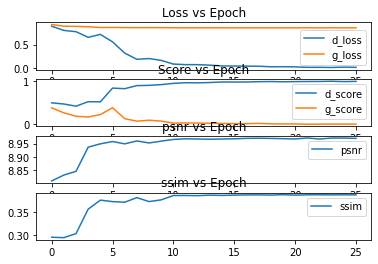

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.tight_layout(pad=3.0)
plt.subplot(411)
plt.plot(results['d_loss'])
plt.plot(results['g_loss'])
plt.legend(["d_loss", "g_loss"])
plt.title("Loss vs Epoch")
plt.subplot(412)
plt.plot(results['d_score'])
plt.plot(results['g_score'])
plt.legend(["d_score", "g_score"])
plt.title("Score vs Epoch")
plt.subplot(413)
plt.plot(results['psnr'])
plt.legend(["psnr"])
plt.title("psnr vs Epoch")
plt.subplot(414)
plt.plot(results['ssim'])
plt.legend(["ssim"])
plt.title("ssim vs Epoch")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input:- torch.Size([4, 3, 64, 64])
Target:- torch.Size([4, 3, 256, 256])
Output:- torch.Size([4, 3, 256, 256])


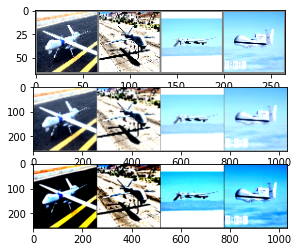

In [8]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
netG.load_state_dict(torch.load('Generated_models/netG25.pt'))
dataiter = iter(testloader1)
images, labels = dataiter.next()

data = images[0].to(device)
target = images[2].to(device)

real_img = Variable(data)
z = Variable(target)
fake_img = (netG(real_img))
print("Input:-", str(real_img.shape))
print("Target:-",str(target.shape))
print("Output:-",str(fake_img.shape))
plt.subplot(311)
general_utils.imshow(torchvision.utils.make_grid(real_img.detach().cpu()))
plt.subplot(312)
general_utils.imshow(torchvision.utils.make_grid(target.detach().cpu()))
plt.subplot(313)
general_utils.imshow1(torchvision.utils.make_grid(fake_img.detach().cpu()))

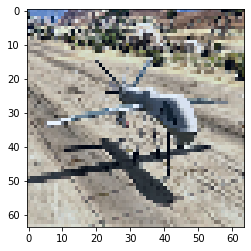

In [9]:
from PIL import Image
import numpy as np
import cv2
#img = (real_img[1]<0)?0:real_img[1]
img = (real_img[1])
img = img.permute(1,2,0)
img = np.array(img.detach().cpu())
img = (img-np.min(img))/(np.max(img)-np.min(img))
from matplotlib import pyplot as plt
plt.imshow(img)
plt.imsave("smallsize.jpg",img)

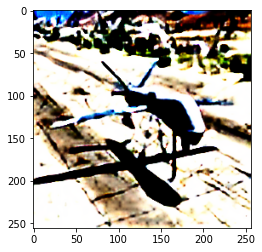

In [10]:
from PIL import Image
import numpy as np
import cv2
img = fake_img[1] 
img = img.permute(1,2,0)
img = np.array(img.detach().cpu())
from matplotlib import pyplot as plt
plt.imshow(img)
plt.imsave("bigsize.jpg",img)

#Load Model

In [11]:
!pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 3.8MB/s 
     |████████████████████████████████| 3.8MB 57.4MB/s 


In [12]:
import io
import numpy as np
import torch.onnx
import copy

In [13]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

In [14]:
print_size_of_model(netG)

Size (MB): 2.973404


In [16]:
# Input to the model
torch_model = copy.deepcopy(netG)
torch_model = torch_model.to(device)
print(next(torch_model.parameters()).is_cuda)
batch_size = 1

x = torch.randn(1,3,256,256).to(device)
torch_out = torch_model(x)

True


#Save onnx model

In [17]:
# Export the model
x = torch.randn(1,3,256,256).to(device)
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "Generated_models/sr_gan.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  # verbose = True,
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=False,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [18]:
torch_out.shape

torch.Size([1, 3, 1024, 1024])

#check size of onnx model

In [19]:
import onnx

onnx_model = onnx.load("Generated_models/sr_gan.onnx")

## verify the model’s structure and confirm that the model has a valid schema ##
onnx.checker.check_model(onnx_model)

In [20]:
print_size_of_onnx_model(onnx_model)

Size (MB): 2.951929


#Load Data

In [21]:
data = Data()
testloader1 = data.getDataLoader(testset, 1)
dataiter = iter(testloader1)

In [23]:
images, labels = dataiter.next()
data1 = Variable(images[1])
image1 = np.array(data1)

#Load onnx model

In [24]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("Generated_models/sr_gan.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
z1 = image1.astype(np.float32) 
ort_inputs = {ort_session.get_inputs()[0].name:z1}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs1 = ort_outs[0]
ort_outs1.shape

(1, 3, 1024, 1024)

#Generate Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


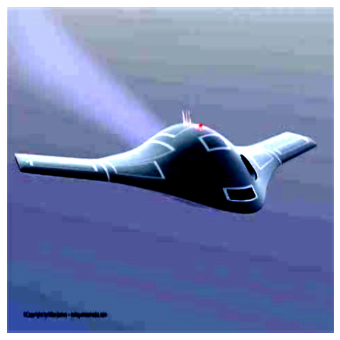

In [29]:
import matplotlib.gridspec as gridspec
img = np.transpose(ort_outs1, (0, 2, 3, 1))
plt.figure(figsize = (6,6))
gs1 = gridspec.GridSpec(6, 6)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
for i in range(1,2):
        plt.subplot(1, 1, i)
        plt.axis('off')
        plt.imshow((img[0]))
plt.show() 

#Original Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


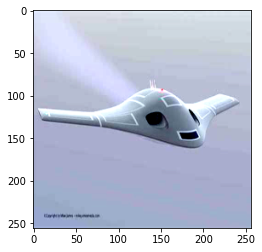

In [26]:
from google.colab.patches import cv2_imshow
general_utils.imshow(torchvision.utils.make_grid(images[1]))